In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import re
import multiprocessing

In [2]:
info = pd.read_excel("做kp.xlsx").dropna()
info.index = range(226)
test = info.drop(columns = ["店铺"])
test

,卖家信用,距今天数,描述相符,宝贝数,好评率,是否金牌卖家,是否有实体店,男装,女装,曝光度,...,运费险,公益宝贝计划,订单险,交易成功比率,蚂蚁花呗支付,信用卡支付,是否直播,7天上新数,30天销售额,销售环比
0,18,1892,4.8,842,0.9952,1,0,1,0,39,...,0,86.300000,0,0.738739,1,1,1,0.0,717800.00,-0.270000
1,13,4688,4.7,23,0.9818,1,0,0,1,0,...,0,0.000000,1,0.629630,1,1,0,0.0,1032200.00,0.550000
2,11,4363,0.0,10,0.9920,0,1,1,0,0,...,0,0.000000,0,0.719298,0,0,0,0.0,3072100.00,-0.330000
3,18,4353,4.7,877,0.9916,1,0,1,0,80,...,0,0.000000,0,0.697286,1,1,0,0.0,1557100.00,0.080000
4,16,4185,4.8,1672,0.9972,1,0,1,1,24,...,1,53.033333,0,0.877551,1,1,1,0.0,284600.00,-0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,11,185,0.0,213,0.9833,0,0,1,0,5,...,0,1.150000,0,0.940035,1,1,0,0.0,10100.00,-0.158004
222,11,297,0.0,94,0.9996,1,1,0,0,18,...,1,4.210000,0,0.747742,1,1,0,0.0,19500.00,-0.202204
223,11,250,0.0,20,0.9977,0,1,0,0,5,...,1,0.000000,0,1.000000,1,1,0,0.0,32800.00,0.107614
224,10,221,0.0,179,0.9782,0,0,1,0,3,...,1,2.730000,0,0.643793,1,1,0,0.0,8071.52,0.540808


In [4]:
type = test.columns
types = pd.DataFrame(type)
types

,0
0,卖家信用
1,距今天数
2,描述相符
3,宝贝数
4,好评率
5,是否金牌卖家
6,是否有实体店
7,男装
8,女装
9,曝光度


In [3]:
data_num = test.drop(columns = ['是否金牌卖家','是否有实体店','男装', '女装','运费险','订单险',"蚂蚁花呗支付","信用卡支付","是否直播"])
data_cat = test[['是否金牌卖家','是否有实体店','男装', '女装','运费险','订单险',"蚂蚁花呗支付","信用卡支付","是否直播"]]
le = preprocessing.LabelEncoder()
data_cat = data_cat.apply(le.fit_transform) #类别型变量如果不是数值，需要先做LabelEncode
test[['卖家信用', '距今天数', '描述相符', '宝贝数','好评率','曝光度', '热度','收藏数中位数', '价格均值', '平均月销量', '发货时间', '公益宝贝计划', '交易成功比率', '7天上新数', '30天销售额', '销售环比']] = test[['卖家信用', '距今天数', '描述相符', '宝贝数','好评率','曝光度', '热度','收藏数中位数', '价格均值', '平均月销量', '发货时间', '公益宝贝计划', '交易成功比率', '7天上新数', '30天销售额', '销售环比']].apply(lambda x: (x - x.mean()) / np.std(x)) #数值型变量做标准化处理，类别型变量如果不是数值，需要先做LabelEncode
test1 = test.values #转化为数组

In [4]:
#用肘部法则来确定最佳的K值
def TrainCluster(df, model_name=None, start_k=1, end_k=20):
    print('training cluster')
    #df = StandardScaler().fit_transform(df) #数据标准化
    K = []
    SSE = []
    silhouette_all=[]
    models = [] #保存每次的模型
    for i in range(start_k, end_k):
        kproto_model = KPrototypes(n_clusters=i, n_jobs=multiprocessing.cpu_count())
        kproto_model.fit(df,categorical=[5,6,7,8,15,17,19,20,21])
        SSE.append(kproto_model.cost_)  # 保存每一个k值的SSE值
        K.append(i)
        print('{}-prototypes SSE loss = {}'.format(i, kproto_model.cost_))
        models.append(kproto_model) #保存每个k值对应的模型

    return(K,SSE,models)

training cluster
2-prototypes SSE loss = 3418.478477645407
3-prototypes SSE loss = 3156.3229541451515
4-prototypes SSE loss = 2911.0915986160917
5-prototypes SSE loss = 2721.4647327104844
6-prototypes SSE loss = 2542.3925850784403
7-prototypes SSE loss = 2408.6590681668226
8-prototypes SSE loss = 2267.197419646193
9-prototypes SSE loss = 2108.433465372656


Text(0.5, 0, '聚类类别数k')

Text(0, 0.5, 'SSE')

([<matplotlib.axis.XTick at 0x14d316e34c8>,
 <a list of 8 Text xticklabel objects>)

Text(0.5, 1.0, '用肘部法则来确定最佳的k值')

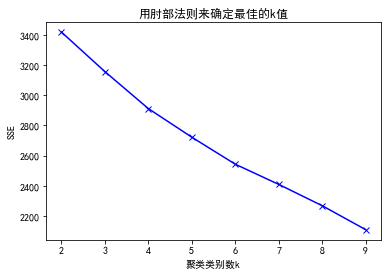

In [5]:
train_cluster_res = TrainCluster(test1,model_name=None, start_k=2, end_k=10 )
K = train_cluster_res[0]
SSE = train_cluster_res[1]
plt.rcParams['font.sans-serif']=['SimHei'] #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False
plt.plot(K, SSE, 'bx-')
plt.xlabel('聚类类别数k')
plt.ylabel('SSE')
plt.xticks(K)
plt.title('用肘部法则来确定最佳的k值')
plt.show()

In [6]:
models = train_cluster_res[2]
best_model = models[K.index(5)]
best_model

KPrototypes(cat_dissim=<function matching_dissim at 0x0000014D7F5FEB88>,
            gamma=0.5000000000000001, init='Cao', max_iter=100, n_clusters=5,
            n_init=10, n_jobs=6,
            num_dissim=<function euclidean_dissim at 0x0000014D7F6035E8>,
            random_state=None, verbose=0)

In [8]:
kp1=best_model.fit_predict(test1, categorical=[5,6,7,8,15,17,19,20,21])
len(kp1)
kp1

226

array([1, 3, 0, 4, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3, 4, 4, 3, 3, 2, 3, 3, 3,
       3, 3, 0, 3, 3, 2, 3, 3, 2, 2, 3, 3, 0, 3, 0, 3, 4, 4, 4, 1, 3, 4,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 3, 0, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 0, 3, 4, 3, 3, 1, 4, 0, 3, 3, 3, 3, 4, 3, 3,
       4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 0, 1, 4, 3, 3,
       3, 4, 4, 4, 4, 3, 4, 4, 0, 4, 0, 0, 4, 3, 4, 3, 4, 0, 1, 4, 4, 3,
       3, 3, 3, 4, 3, 4, 3, 2, 3, 0, 3, 2, 0, 1, 1, 3, 2, 3, 0, 3, 0, 3,
       0, 4, 3, 3, 3, 0, 3, 3, 3, 0, 3, 4, 0, 3, 0, 3, 0, 0, 3, 3, 3, 3,
       0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 1, 0, 3, 0, 3, 0,
       3, 0, 0, 0, 0, 0], dtype=uint16)

In [417]:
centroids = best_model.cluster_centroids_
centroids

array([[ 0.50148768,  0.25529052,  0.35721641,  0.40208004,  0.27060629,
         2.03922483,  1.86808827, -0.01747788,  0.55370502,  0.28207348,
        -0.14080816, -0.10076948, -0.08915622, -0.01554216,  0.47902156,
        -0.12256184,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ],
       [ 2.3614256 , -0.22041604,  0.44005689,  2.56705336,  0.18009352,
         1.01048144,  1.42013475,  4.36768159, -0.58120067,  0.27210179,
        -0.03073832,  3.18735487, -0.0470056 ,  1.60554109,  0.32913712,
        -0.25021516,  1.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.08833971,  0.01563111,  0.43144235, -0.08242507,  0.12084212,
        -0.41733576, -0.42831864, -0.13678222, -0.08071516, -0.12969476,
        -0.1964997 , -0.08679383,  0.02394257, -0.08326098, -0.19301038,
         0.03391936,  1.        ,  0.        ,  0

In [451]:
results = pd.read_excel("最全40个指标.xlsx").dropna()[["店铺","7天上新数","30天销售额","销售环比","运费险","卖家信用","服务态度","保证金","是否金牌卖家","平均月销量","宝贝数"]]
results.index = range(226)
results[["7天上新数","30天销售额","销售环比","卖家信用","服务态度","保证金","平均月销量","宝贝数"]] = results[["7天上新数","30天销售额","销售环比","卖家信用","服务态度","保证金","平均月销量","宝贝数"]].apply(lambda x: (x - x.mean()) / np.std(x))
labels = np.array(kp1)
results["labels"] = labels

,店铺,7天上新数,30天销售额,销售环比,运费险,卖家信用,服务态度,保证金,是否金牌卖家,平均月销量,宝贝数,labels
0,港仔先生,-0.32406,-0.226496,-0.496531,0,1.911441,0.457926,-0.112612,1,-0.068241,-0.091177,4
1,与乐共存,-0.32406,-0.119104,0.625574,0,-0.338484,0.457926,-0.170325,1,-0.160936,-0.635449,2
2,纯棉9年老店T恤衫制衣厂,-0.32406,0.577678,-0.578636,0,-1.238454,-2.324565,-0.155897,0,3.549816,-0.644089,3
3,旋律风车潮流男装,-0.32406,0.060189,-0.017584,0,1.911441,0.457926,-0.040471,1,-0.101599,-0.067917,0
4,奢华广场美国代购,-0.32406,-0.374467,-0.400741,1,1.011471,0.457926,0.536674,1,-0.162542,0.460406,2
...,...,...,...,...,...,...,...,...,...,...,...,...
221,波妞家女装批发折扣店,-0.32406,-0.468229,-0.343273,0,-1.238454,-2.324565,-0.169604,0,-0.144126,-0.509183,3
222,花花公子大码服饰,-0.32406,-0.465019,-0.403758,1,-1.238454,-2.324565,-0.155883,1,-0.153013,-0.588266,3
223,博登运动的小店,-0.32406,-0.460476,0.020203,1,-1.238454,-2.324565,-0.152598,0,-0.142315,-0.637443,3
224,木子服饰网批,-0.32406,-0.468922,0.612995,1,-1.688439,-2.324565,-0.155608,0,-0.167134,-0.531778,3


In [452]:
results[["店铺","labels"]].groupby("labels").describe()

店铺                        
       count unique         top freq
labels                              
0         30     30      柚子先生原创    1
1          7      7       可可麻豆家    1
2        136    136       五号夜衣馆    1
3         41     41  运动三叶草品牌折扣店    1
4         12     12  WENGNA翁娜丁琼    1

In [460]:
cat0 = results[results["labels"]==0]
cat1 = results[results["labels"]==1]
cat2 = results[results["labels"]==2]
cat3 = results[results["labels"]==3]
cat4 = results[results["labels"]==4]
x0 = cat0.describe().iloc[1]
x1 = cat1.describe().iloc[1]
x2 = cat2.describe().iloc[1]
x3 = cat3.describe().iloc[1]
x4 = cat4.describe().iloc[1]
final = pd.DataFrame([x0,x1,x2,x3,x4])
final.to_excel("生成评分.xlsx")

In [461]:
cat00 = info[results["labels"]==0].describe()
cat11 = info[results["labels"]==1].describe()
cat22 = info[results["labels"]==2].describe()
cat33 = info[results["labels"]==3].describe()
cat44 = info[results["labels"]==4].describe()

In [469]:
cat00.to_excel("kp-0.xlsx")

In [470]:
cat11.to_excel("kp-1.xlsx")

In [471]:
cat22.to_excel("kp-2.xlsx")

In [472]:
cat33.to_excel("kp-3.xlsx")

In [473]:
cat44.to_excel("kp-4.xlsx")

In [468]:
info.to_excel("kp最终结果.xlsx")